# Harmonic Networks: Predicting Only Human Pose Masks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import os
import cv2
import sys
from keras.utils import to_categorical
import time
import torch
import torch.nn as nn
from torch_localize import localized_module
from torch_dimcheck import dimchecked
from harmonic.d2 import HConv2d, ScalarGate2d, avg_pool2d, BatchNorm2d, upsample_2d, cat2d, Dropout2d, HConv2dTranspose
from harmonic.cmplx import from_real
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F

Using TensorFlow backend.


## Training and Validation Set

In [2]:
image_adr = 'SMALL_5K_IMAGES/'
mask_adr = 'SMALL_5K_MASKS/'

images = sorted(os.listdir(image_adr))
masked = sorted(os.listdir(mask_adr))

In [3]:
print(len(images))
print(len(masked))

5000
5000


In [4]:
np.random.seed(23)
order = np.random.permutation(len(images))
X_train = order[:int(0.8*len(order))]
X_valid = order[int(0.8*len(order)):]
print(len(X_train))
print(len(X_valid))

4000
1000


## Dataset

In [5]:
class Images(Dataset):

    def __init__(self, X_names, y_names, indices):
        self.X_names = X_names
        self.y_names = y_names
        self.indices = indices
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        X_name = image_adr + self.X_names[self.indices[idx]]
        y_name = mask_adr + self.y_names[self.indices[idx]]
        
        X = cv2.cvtColor(cv2.imread(X_name), cv2.COLOR_BGR2RGB).astype('float32')
        X /= 255
        
        r = X.shape[0]
        c = X.shape[1]
        r_pad = 0
        c_pad = 0
        
        while r % 16 != 0:
            r_pad += 1
            r += 1
            
        while c % 16 != 0:
            c_pad += 1
            c += 1
            
        X = np.pad(X, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X = self.to_tensor(X)
        
        y = (cv2.imread(y_name, 0) > 200).astype('float32')
        y = np.pad(y, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        y = to_categorical(y, 2)
        y = self.to_tensor(y)

        return {'X': X, 'y': y}

## Model

In [6]:
@localized_module
class FinalConvBlock(nn.Module):
    def __init__(self, in_repr, out_repr, size=3, pad=False):
        super(FinalConvBlock, self).__init__()

        self.in_repr = in_repr
        self.out_repr = out_repr
        
        self.conv1 = HConv2d(in_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})

    def forward(self, x):
        y = x
        
        y = self.conv1(y)
        y = y[0, ...]
        y = torch.nn.Softmax(1)(y)

        return y

@localized_module
class HNetConvBlock(nn.Module):
    def __init__(self, in_repr, out_repr, size=3, pad=False):
        super(HNetConvBlock, self).__init__()

        self.in_repr = in_repr
        self.out_repr = out_repr
        
        self.nonl1 = ScalarGate2d(out_repr)
        self.nonl2 = ScalarGate2d(out_repr)
        
        self.bnorm1 = BatchNorm2d(out_repr)
        self.bnorm2 = BatchNorm2d(out_repr)

        self.conv1 = HConv2d(in_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})
        self.conv2 = HConv2d(out_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})
        self.dropout = Dropout2d(p=0.1)

    def forward(self, x):
        y = x
        
        y = self.conv1(y)
        y = self.bnorm1(y)
        y = self.nonl1(y)
        y = self.conv2(y)
        y = self.bnorm2(y)
        y = self.nonl2(y)
        y = self.dropout(y)

        return y
    
@localized_module
class HNetUpSampleBlock(nn.Module):
    def __init__(self, in_repr, out_repr, size=3):
        super(HNetUpSampleBlock, self).__init__()

        self.in_repr = in_repr
        self.out_repr = out_repr
        self.nonl = ScalarGate2d(out_repr)
        self.bnorm1 = BatchNorm2d(out_repr)
        self.conv = HConv2d(in_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})
        #self.conv = HConv2dTranspose(in_repr, out_repr, 2, conv_kwargs={'stride':2})


    def forward(self, x):
        y = x
        y = upsample_2d(y)
        y = self.conv(y)
        y = self.bnorm1(y)
        y = self.nonl(y)

        return y

In [7]:
layers = [(3,),
         (32,32),
         (64,64),
         (128,128),
         (256,256),
         (512,512)]

class HNet(nn.Module):

    def __init__(self, kernel):
        super(HNet, self).__init__()
        
        self.kernel_size = kernel
        
        self.conv_down1 = HNetConvBlock(layers[0], layers[1])
        self.conv_down2 = HNetConvBlock(layers[1], layers[2])
        self.conv_down3 = HNetConvBlock(layers[2], layers[3])
        self.conv_down4 = HNetConvBlock(layers[3], layers[4])
        self.conv_down5 = HNetConvBlock(layers[4], layers[5])
        
        self.conv_upsample1 = HNetUpSampleBlock(layers[5], layers[4], self.kernel_size)
        self.conv_up1 = HNetConvBlock(layers[5], layers[4])
        
        self.conv_upsample2 = HNetUpSampleBlock(layers[4], layers[3], self.kernel_size)
        self.conv_up2 = HNetConvBlock(layers[4], layers[3])
        
        self.conv_upsample3 = HNetUpSampleBlock(layers[3], layers[2], self.kernel_size)
        self.conv_up3 = HNetConvBlock(layers[3], layers[2])
        
        self.conv_upsample4 = HNetUpSampleBlock(layers[2], layers[1], self.kernel_size)
        self.conv_up4 = HNetConvBlock(layers[2], layers[1])

        self.conv_up5 = FinalConvBlock(layers[1], (2,))
        

    @dimchecked
    def forward(self, x: ['n', 3, 'wi', 'hi']) -> ['n', -1, 'wo', 'ho']:
        x = from_real(x)
        y = x
        
        conv1 = self.conv_down1(y)
        pool1 = avg_pool2d(conv1, kernel_size=2)

        conv2 = self.conv_down2(pool1)
        pool2 = avg_pool2d(conv2, kernel_size=2)
        
        conv3 = self.conv_down3(pool2)
        pool3 = avg_pool2d(conv3, kernel_size=2)
        
        conv4 = self.conv_down4(pool3)
        pool4 = avg_pool2d(conv4, kernel_size=2)
        
        conv5 = self.conv_down5(pool4)

        up6 = self.conv_upsample1(conv5)
        merge6 = cat2d(conv4, layers[4], up6, layers[4])
        conv6 = self.conv_up1(merge6)
        
        up7 = self.conv_upsample2(conv6)
        merge7 = cat2d(conv3, layers[3], up7, layers[3])
        conv7 = self.conv_up2(merge7)

        up8 = self.conv_upsample3(conv7)
        merge8 = cat2d(conv2, layers[2], up8, layers[2])
        conv8 = self.conv_up3(merge8)
        
        up9 = self.conv_upsample4(conv8)
        merge9 = cat2d(conv1, layers[1], up9, layers[1])
        conv9 = self.conv_up4(merge9)
        
        output = self.conv_up5(conv9)
        
        return output

## Metrics

In [8]:
def dice_coef(input_, target):
    smooth = 1e-6
    iflat = input_[:,1,:,:]
    tflat = target[:,1,:,:]
    intersection = (iflat * tflat).sum(dim=(2,1))
    return torch.mean((2. * intersection + smooth) / (iflat.sum(dim=(2,1)) + tflat.sum(dim=(2,1)) + smooth))

def dice_loss(input_, target):
    return 1-dice_coef(input_, target)

def dice_coef_hard(input_, target):
    iflat = torch.argmax(input_, dim=1).type(torch.cuda.FloatTensor)
    tflat = target[:,1,:,:]
    intersection = (iflat * tflat).sum(dim=(2,1))
    return torch.mean((2. * intersection) / (iflat.sum(dim=(2,1)) + tflat.sum(dim=(2,1))))

## Training

In [9]:
batch_size = 1
n_epochs = 30

In [10]:
train = DataLoader(Images(images, masked, X_train), batch_size=batch_size, num_workers=8, shuffle=False)
valid = DataLoader(Images(images, masked, X_valid), batch_size=batch_size, num_workers=8, shuffle=False)

net = HNet(kernel=3)

loss_fn = dice_loss
acc_soft = dice_coef
acc_hard = dice_coef_hard

n_params = 0

for param in net.parameters():
    n_params += param.numel()
    
print('n params:', n_params)

cuda = torch.cuda.is_available()
if cuda:
    net = net.cuda()
    
optimizer = torch.optim.Adam(net.parameters(), lr=2e-5)

n params: 13430240


In [11]:
v_loss = []
v_ds = []
v_dh = []

t_loss = []
t_ds = []
t_dh = []

for ep in range(n_epochs):
    
    with tqdm(total=len(train), dynamic_ncols=True) as progress:
        
        loss_ = 0.
        acc_ = 0.
        acc_h_ = 0.
        
        progress.set_description('Epoch: %s' % str(ep+1))

        for idx, batch_data in enumerate(train):
            X, y = batch_data['X'].cuda(), batch_data['y'].cuda()

            optimizer.zero_grad()
            
            output = net(X)
            
            loss = loss_fn(output, y)
            acc_s = acc_soft(output, y)
            acc_h = acc_hard(output, y)
            
            loss.backward()
            optimizer.step()
            
            progress.update(1)
            
            loss_ += loss.item()
            acc_ += acc_s.item()
            acc_h_ += acc_h.item()
            
            progress.set_postfix(loss=loss_/(idx+1), dice_soft=acc_/(idx+1), dice_hard=acc_h_/(idx+1))

        loss_ /= len(train)
        acc_ /= len(train)
        acc_h_ /= len(train)
        
    progress.write('Validating ...')
    
    net.eval()
    
    with torch.no_grad():
        
        val_loss_ = 0.
        val_acc_ = 0.
        val_acc_h_ = 0.

        for idx, batch_data in enumerate(valid):
            X, y = batch_data['X'].cuda(), batch_data['y'].cuda()

            output = net(X)

            val_loss = loss_fn(output, y)
            val_acc_s = acc_soft(output, y)
            val_acc_h = acc_hard(output, y)

            val_loss_ += val_loss.item()
            val_acc_ += val_acc_s.item()
            val_acc_h_ += val_acc_h.item()

        val_loss_ /= len(valid)
        val_acc_ /= len(valid)
        val_acc_h_ /= len(valid)
        
        t_dh.append(acc_h_)
        t_ds.append(acc_)
        t_loss.append(loss_)
        
        v_dh.append(val_acc_h_)
        v_ds.append(val_acc_)
        v_loss.append(val_loss_)

        progress.write('Training Dice Loss: {:.3f} - Training Dice Soft: {:.3f} - Training Dice Hard: {:.3f}\nValidation Dice Loss: {:.3f} - Validation Dice Soft: {:.3f} - Validation Dice Hard: {:.3f}'.format(
            loss_, acc_, acc_h_, val_loss_, val_acc_, val_acc_h_))
        
    net.train()
        


Validating ...
Training Dice Loss: 0.293 - Training Dice Soft: 0.707 - Training Dice Hard: 0.714
Validation Dice Loss: 0.211 - Validation Dice Soft: 0.789 - Validation Dice Hard: 0.792



Validating ...
Training Dice Loss: 0.201 - Training Dice Soft: 0.799 - Training Dice Hard: 0.802
Validation Dice Loss: 0.186 - Validation Dice Soft: 0.814 - Validation Dice Hard: 0.816



Validating ...
Training Dice Loss: 0.175 - Training Dice Soft: 0.825 - Training Dice Hard: 0.827
Validation Dice Loss: 0.168 - Validation Dice Soft: 0.832 - Validation Dice Hard: 0.833



Validating ...
Training Dice Loss: 0.156 - Training Dice Soft: 0.844 - Training Dice Hard: 0.845
Validation Dice Loss: 0.151 - Validation Dice Soft: 0.849 - Validation Dice Hard: 0.850



Validating ...
Training Dice Loss: 0.145 - Training Dice Soft: 0.855 - Training Dice Hard: 0.856
Validation Dice Loss: 0.141 - Validation Dice Soft: 0.859 - Validation Dice Hard: 0.859



Validating ...
Training Dice Loss: 0.136 - Training Dice Soft: 0.864 - Training Dice Hard: 0.864
Validation Dice Loss: 0.137 - Validation Dice Soft: 0.863 - Validation Dice Hard: 0.864



Validating ...
Training Dice Loss: 0.128 - Training Dice Soft: 0.872 - Training Dice Hard: 0.873
Validation Dice Loss: 0.129 - Validation Dice Soft: 0.871 - Validation Dice Hard: 0.872



Validating ...
Training Dice Loss: 0.121 - Training Dice Soft: 0.879 - Training Dice Hard: 0.880
Validation Dice Loss: 0.129 - Validation Dice Soft: 0.871 - Validation Dice Hard: 0.872



Validating ...
Training Dice Loss: 0.117 - Training Dice Soft: 0.883 - Training Dice Hard: 0.884
Validation Dice Loss: 0.123 - Validation Dice Soft: 0.877 - Validation Dice Hard: 0.877



Validating ...
Training Dice Loss: 0.114 - Training Dice Soft: 0.886 - Training Dice Hard: 0.886
Validation Dice Loss: 0.120 - Validation Dice Soft: 0.880 - Validation Dice Hard: 0.881



Validating ...
Training Dice Loss: 0.106 - Training Dice Soft: 0.894 - Training Dice Hard: 0.894
Validation Dice Loss: 0.118 - Validation Dice Soft: 0.882 - Validation Dice Hard: 0.882



Validating ...
Training Dice Loss: 0.105 - Training Dice Soft: 0.895 - Training Dice Hard: 0.896
Validation Dice Loss: 0.116 - Validation Dice Soft: 0.884 - Validation Dice Hard: 0.885



Validating ...
Training Dice Loss: 0.102 - Training Dice Soft: 0.898 - Training Dice Hard: 0.899
Validation Dice Loss: 0.114 - Validation Dice Soft: 0.886 - Validation Dice Hard: 0.886



Validating ...
Training Dice Loss: 0.097 - Training Dice Soft: 0.903 - Training Dice Hard: 0.903
Validation Dice Loss: 0.111 - Validation Dice Soft: 0.889 - Validation Dice Hard: 0.889



Validating ...
Training Dice Loss: 0.095 - Training Dice Soft: 0.905 - Training Dice Hard: 0.905
Validation Dice Loss: 0.112 - Validation Dice Soft: 0.888 - Validation Dice Hard: 0.888



Validating ...
Training Dice Loss: 0.091 - Training Dice Soft: 0.909 - Training Dice Hard: 0.909
Validation Dice Loss: 0.111 - Validation Dice Soft: 0.889 - Validation Dice Hard: 0.889



Validating ...
Training Dice Loss: 0.090 - Training Dice Soft: 0.910 - Training Dice Hard: 0.911
Validation Dice Loss: 0.118 - Validation Dice Soft: 0.882 - Validation Dice Hard: 0.882



Validating ...
Training Dice Loss: 0.088 - Training Dice Soft: 0.912 - Training Dice Hard: 0.912
Validation Dice Loss: 0.107 - Validation Dice Soft: 0.893 - Validation Dice Hard: 0.893



Validating ...
Training Dice Loss: 0.085 - Training Dice Soft: 0.915 - Training Dice Hard: 0.915
Validation Dice Loss: 0.106 - Validation Dice Soft: 0.894 - Validation Dice Hard: 0.894



Validating ...
Training Dice Loss: 0.083 - Training Dice Soft: 0.917 - Training Dice Hard: 0.918
Validation Dice Loss: 0.107 - Validation Dice Soft: 0.893 - Validation Dice Hard: 0.893



Validating ...
Training Dice Loss: 0.081 - Training Dice Soft: 0.919 - Training Dice Hard: 0.919
Validation Dice Loss: 0.104 - Validation Dice Soft: 0.896 - Validation Dice Hard: 0.896



Validating ...
Training Dice Loss: 0.080 - Training Dice Soft: 0.920 - Training Dice Hard: 0.921
Validation Dice Loss: 0.106 - Validation Dice Soft: 0.894 - Validation Dice Hard: 0.894



Validating ...
Training Dice Loss: 0.078 - Training Dice Soft: 0.922 - Training Dice Hard: 0.923
Validation Dice Loss: 0.104 - Validation Dice Soft: 0.896 - Validation Dice Hard: 0.896



Validating ...
Training Dice Loss: 0.077 - Training Dice Soft: 0.923 - Training Dice Hard: 0.924
Validation Dice Loss: 0.101 - Validation Dice Soft: 0.899 - Validation Dice Hard: 0.899



Validating ...
Training Dice Loss: 0.074 - Training Dice Soft: 0.926 - Training Dice Hard: 0.926
Validation Dice Loss: 0.099 - Validation Dice Soft: 0.901 - Validation Dice Hard: 0.901



Validating ...
Training Dice Loss: 0.073 - Training Dice Soft: 0.927 - Training Dice Hard: 0.927
Validation Dice Loss: 0.102 - Validation Dice Soft: 0.898 - Validation Dice Hard: 0.898



Validating ...
Training Dice Loss: 0.071 - Training Dice Soft: 0.929 - Training Dice Hard: 0.929
Validation Dice Loss: 0.101 - Validation Dice Soft: 0.899 - Validation Dice Hard: 0.900



Validating ...
Training Dice Loss: 0.071 - Training Dice Soft: 0.929 - Training Dice Hard: 0.929
Validation Dice Loss: 0.099 - Validation Dice Soft: 0.901 - Validation Dice Hard: 0.901



Validating ...
Training Dice Loss: 0.070 - Training Dice Soft: 0.930 - Training Dice Hard: 0.930
Validation Dice Loss: 0.101 - Validation Dice Soft: 0.899 - Validation Dice Hard: 0.899



Validating ...
Training Dice Loss: 0.068 - Training Dice Soft: 0.932 - Training Dice Hard: 0.932
Validation Dice Loss: 0.097 - Validation Dice Soft: 0.903 - Validation Dice Hard: 0.903


## Model Performance

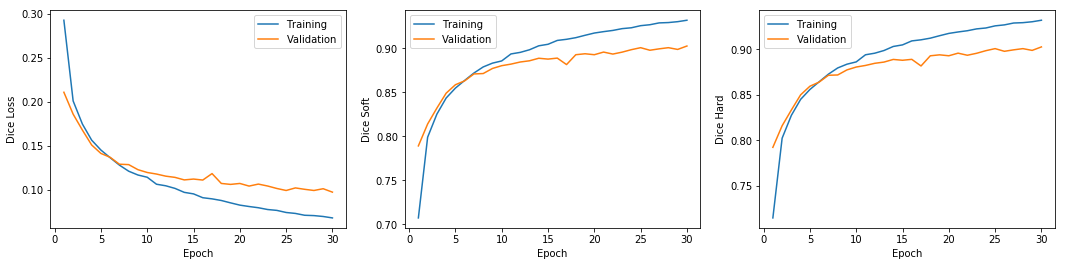

In [13]:
f, ax = plt.subplots(1,3, figsize=(18,4))

v_ = [v_loss, v_ds, v_dh]
t_ = [t_loss, t_ds, t_dh]
label_ = ['Dice Loss', 'Dice Soft', 'Dice Hard']

for i in range(3):
    ax[i].plot(range(1,31), t_[i], label='Training')
    ax[i].plot(range(1,31), v_[i], label='Validation')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(label_[i])
    ax[i].legend()

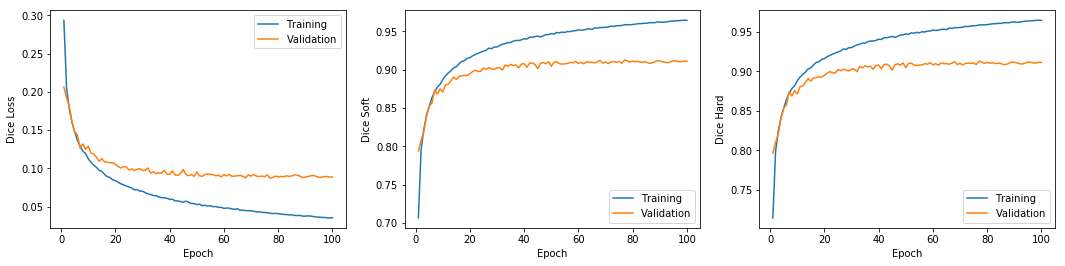

In [12]:
f, ax = plt.subplots(1,3, figsize=(18,4))

v_ = [v_loss, v_ds, v_dh]
t_ = [t_loss, t_ds, t_dh]
label_ = ['Dice Loss', 'Dice Soft', 'Dice Hard']

for i in range(3):
    ax[i].plot(range(1,101), t_[i], label='Training')
    ax[i].plot(range(1,101), v_[i], label='Validation')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(label_[i])
    ax[i].legend()

## Sample Predictions

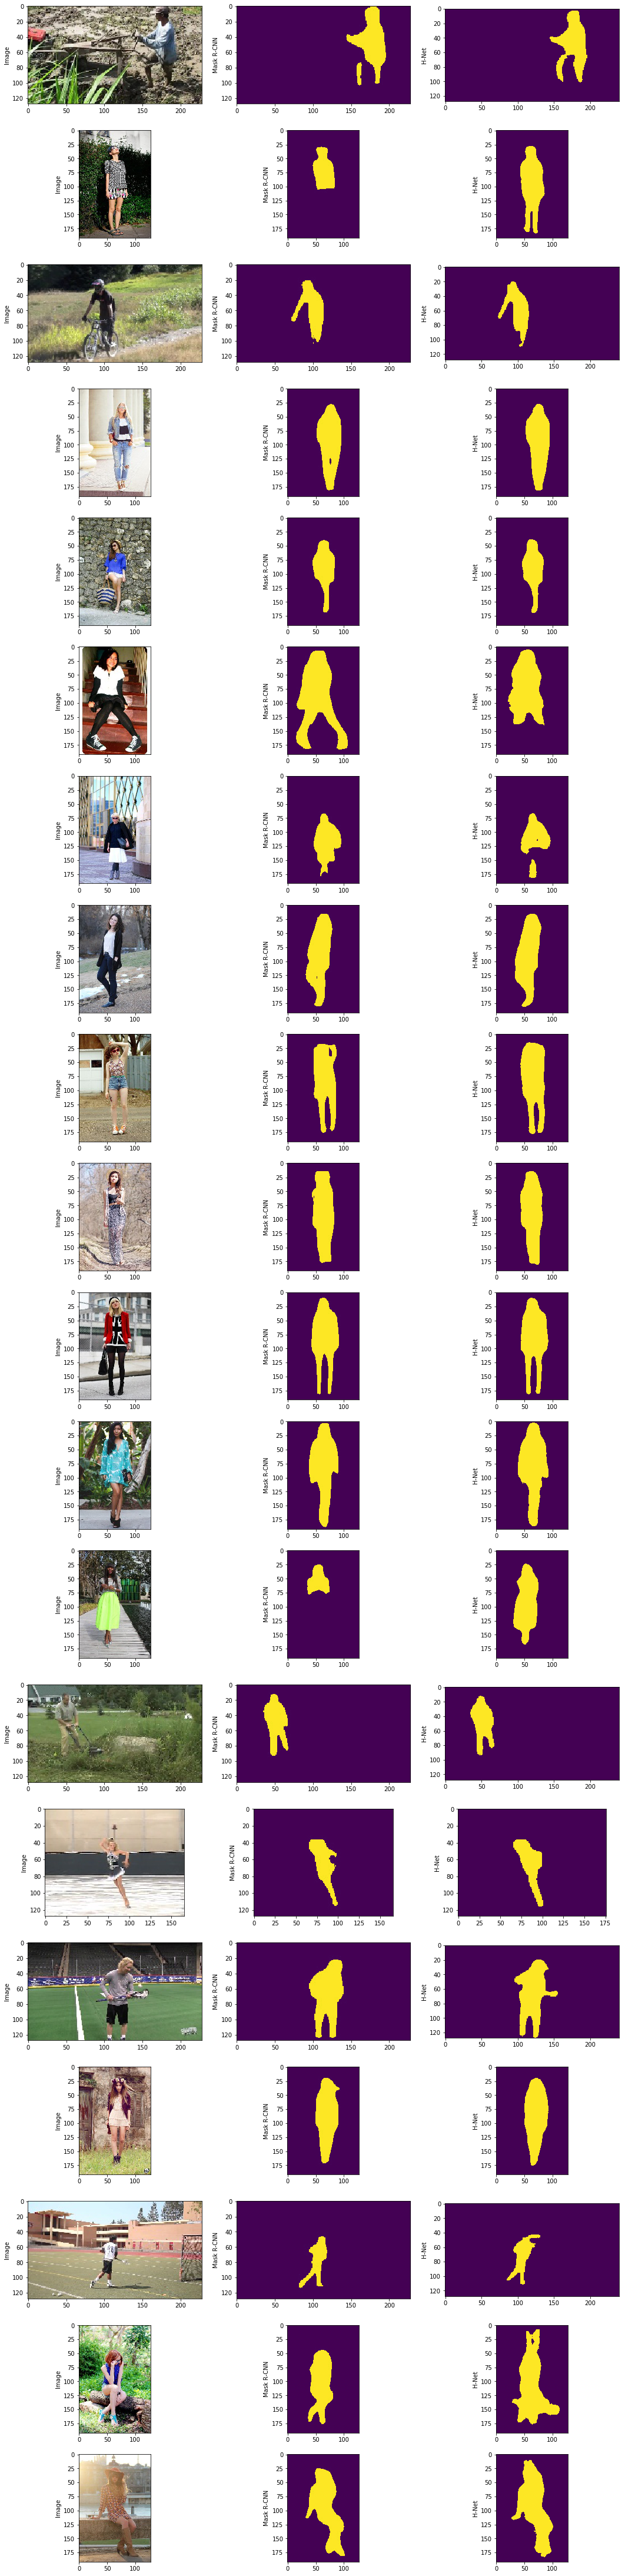

In [13]:
results = []

with torch.no_grad():
    for idx, batch_data in enumerate(valid):
        X, y = batch_data['X'].cuda(), batch_data['y'].cuda()
        output = torch.argmax(net(X), dim=1)
        results.append(output)
        
        if idx == 20:
            break
            
image_list = X_valid[:20]

f, ax = plt.subplots(20,3, figsize=(18,80))
c_ = 0

for i in range(20):
    X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[i]]), cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(X_batch)
    ax[i,1].imshow(cv2.imread(mask_adr + images[image_list[i]], 0))
    ax[i,2].imshow(results[i].squeeze().cpu().numpy())
    c_ += 1

for j in range(20):
    _ = ax[j,0].set_ylabel('Image')
    _ = ax[j,1].set_ylabel('Mask R-CNN')
    _ = ax[j,2].set_ylabel('H-Net')

## Model Save & Load

In [16]:
torch.save(net.state_dict(), 'harmonic_100ep_adam2e5_3232_512512_drop_bnorm.pt')
#model = torch.load('harmonic_100ep_adam2e5_3232_512512_drop_bnorm.pt')
#model.eval()

In [11]:
the_model = HNet(3)
the_model.load_state_dict(torch.load('harmonic_100ep_adam2e5_3232_512512_drop_bnorm.pt'))
the_model.eval()

HNet(
  (conv_down1): HNetConvBlock(
    (nonl1): ScalarGate2d(repr=(32, 32), mult=1)
    (nonl2): ScalarGate2d(repr=(32, 32), mult=1)
    (bnorm1): BatchNorm2d(repr=(32, 32), eps=0.01)
    (bnorm2): BatchNorm2d(repr=(32, 32), eps=0.01)
    (conv1): HConv2d(in=(3,), out=(32, 32), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (conv2): HConv2d(in=(32, 32), out=(32, 32), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (dropout): Dropout2d(p=0.1)
  )
  (conv_down2): HNetConvBlock(
    (nonl1): ScalarGate2d(repr=(64, 64), mult=1)
    (nonl2): ScalarGate2d(repr=(64, 64), mult=1)
    (bnorm1): BatchNorm2d(repr=(64, 64), eps=0.01)
    (bnorm2): BatchNorm2d(repr=(64, 64), eps=0.01)
    (conv1): HConv2d(in=(32, 32), out=(64, 64), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (conv2): HConv2d(in=(64, 64), out=(64, 64), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (dropout): Dropout2d(p=0.1)
  )
  (conv_down3): HNetConvBlock(
    (